In [1]:
# Task 4: RFM Clustering for Proxy Target
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

print("Libraries loaded")

Libraries loaded


In [2]:
# Load the features created in Task 3
df = pd.read_csv("../data/processed/features_data.csv")
print(f"Loaded {len(df)} transactions, {len(df.columns)} columns")

# Get unique customers with their RFM metrics
customer_cols = ['AccountId_numeric', 'Recency', 'Frequency', 'Monetary_Total']
customer_rfm = df[customer_cols].drop_duplicates()
print(f"Unique customers: {len(customer_rfm)}")

Loaded 95662 transactions, 31 columns
Unique customers: 3633


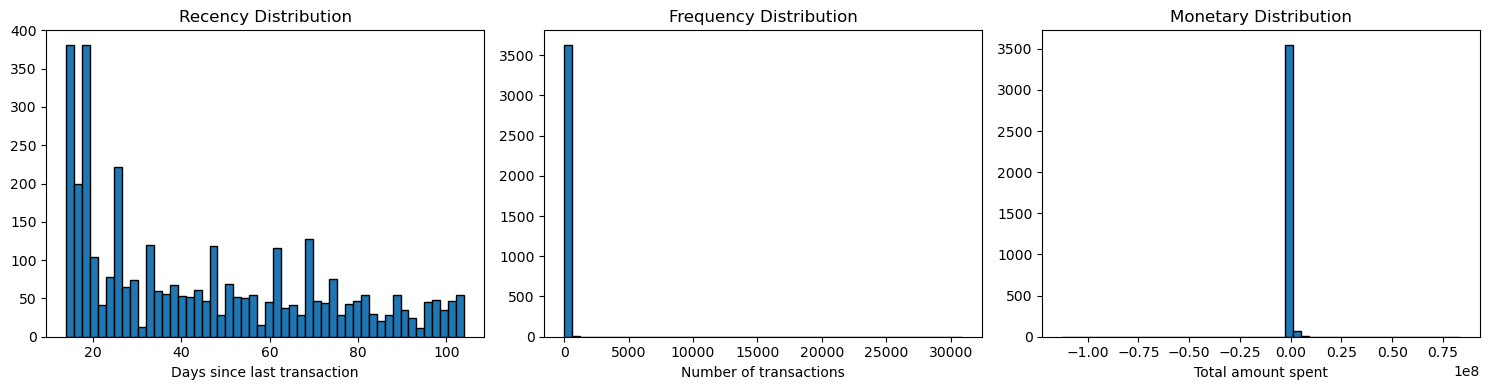

In [4]:
# Visualize RFM distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(customer_rfm['Recency'], bins=50, edgecolor='black')
axes[0].set_title('Recency Distribution')
axes[0].set_xlabel('Days since last transaction')

axes[1].hist(customer_rfm['Frequency'], bins=50, edgecolor='black')
axes[1].set_title('Frequency Distribution')
axes[1].set_xlabel('Number of transactions')

axes[2].hist(customer_rfm['Monetary_Total'], bins=50, edgecolor='black')
axes[2].set_title('Monetary Distribution')
axes[2].set_xlabel('Total amount spent')

plt.tight_layout()
plt.show()

In [5]:
# Scale the features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(customer_rfm[['Recency', 'Frequency', 'Monetary_Total']])

# Apply KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
customer_rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

print("Clustering complete!")
print(customer_rfm['Cluster'].value_counts().sort_index())

Clustering complete!
Cluster
0    2256
1    1376
2       1
Name: count, dtype: int64


Cluster RFM Averages:
         Recency  Frequency  Monetary_Total
Cluster                                    
0          26.34      23.38       292343.93
1          75.15       8.75         7896.08
2          14.00   30893.00    -27750277.50


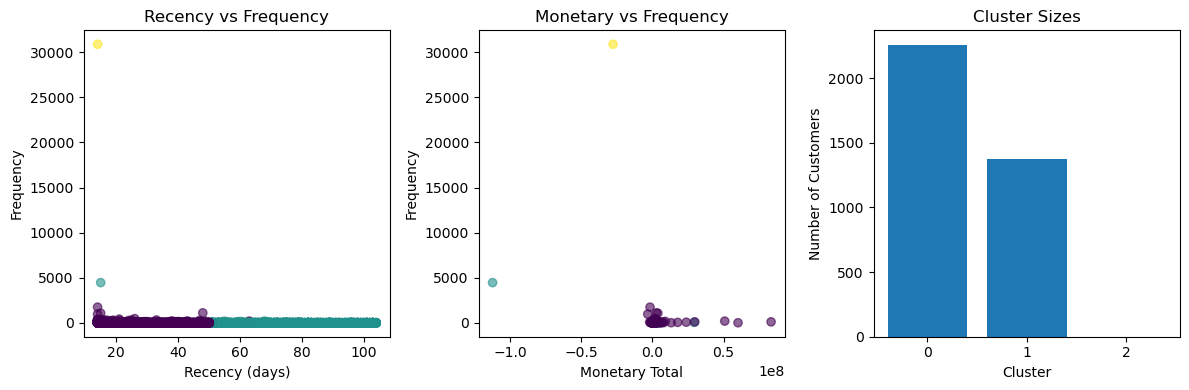

In [6]:
# Analyze cluster characteristics
cluster_stats = customer_rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary_Total': 'mean'
}).round(2)

print("Cluster RFM Averages:")
print(cluster_stats)

# Visualize clusters
fig = plt.figure(figsize=(12, 4))

# Plot 1: Recency vs Frequency
ax1 = fig.add_subplot(131)
scatter = ax1.scatter(customer_rfm['Recency'], customer_rfm['Frequency'], 
                     c=customer_rfm['Cluster'], cmap='viridis', alpha=0.6)
ax1.set_xlabel('Recency (days)')
ax1.set_ylabel('Frequency')
ax1.set_title('Recency vs Frequency')

# Plot 2: Monetary vs Frequency
ax2 = fig.add_subplot(132)
ax2.scatter(customer_rfm['Monetary_Total'], customer_rfm['Frequency'], 
           c=customer_rfm['Cluster'], cmap='viridis', alpha=0.6)
ax2.set_xlabel('Monetary Total')
ax2.set_ylabel('Frequency')
ax2.set_title('Monetary vs Frequency')

# Plot 3: Cluster sizes
ax3 = fig.add_subplot(133)
cluster_counts = customer_rfm['Cluster'].value_counts().sort_index()
ax3.bar(cluster_counts.index, cluster_counts.values)
ax3.set_xlabel('Cluster')
ax3.set_ylabel('Number of Customers')
ax3.set_title('Cluster Sizes')
ax3.set_xticks([0, 1, 2])

plt.tight_layout()
plt.show()

In [7]:
# Define risk logic: High Recency + Low Frequency + Low Monetary = High Risk
# Calculate risk score for each cluster
cluster_stats['Risk_Score'] = (
    cluster_stats['Recency'] * 0.5 +  # Higher recency = higher risk
    (1 / (cluster_stats['Frequency'] + 1)) * 0.3 +  # Lower frequency = higher risk
    (1 / (cluster_stats['Monetary_Total'].abs() + 1)) * 0.2  # Lower monetary = higher risk
)

print("Cluster Risk Scores:")
print(cluster_stats[['Risk_Score']])

high_risk_cluster = cluster_stats['Risk_Score'].idxmax()
print(f"\n🎯 HIGH-RISK CLUSTER: Cluster {high_risk_cluster}")
print(f"   Characteristics:")
print(f"   - Recency: {cluster_stats.loc[high_risk_cluster, 'Recency']:.1f} days (higher = riskier)")
print(f"   - Frequency: {cluster_stats.loc[high_risk_cluster, 'Frequency']:.1f} transactions (lower = riskier)")
print(f"   - Monetary: ${cluster_stats.loc[high_risk_cluster, 'Monetary_Total']:.2f} (lower = riskier)")

Cluster Risk Scores:
         Risk_Score
Cluster            
0         13.182306
1         37.605795
2          7.000010

🎯 HIGH-RISK CLUSTER: Cluster 1
   Characteristics:
   - Recency: 75.2 days (higher = riskier)
   - Frequency: 8.8 transactions (lower = riskier)
   - Monetary: $7896.08 (lower = riskier)


In [8]:
# Create binary label
customer_rfm['is_high_risk'] = (customer_rfm['Cluster'] == high_risk_cluster).astype(int)

# Calculate risk rate
risk_rate = customer_rfm['is_high_risk'].mean() * 100
print(f"📊 RISK DISTRIBUTION:")
print(f"   High-risk customers: {customer_rfm['is_high_risk'].sum()} out of {len(customer_rfm)} ({risk_rate:.1f}%)")
print(f"   Low-risk customers: {(customer_rfm['is_high_risk'] == 0).sum()} out of {len(customer_rfm)} ({100-risk_rate:.1f}%)")

# Save the labels
customer_rfm[['AccountId_numeric', 'is_high_risk']].to_csv(
    "../data/processed/high_risk_labels.csv", index=False
)
print("\n✅ Labels saved to: ../data/processed/high_risk_labels.csv")

📊 RISK DISTRIBUTION:
   High-risk customers: 1376 out of 3633 (37.9%)
   Low-risk customers: 2257 out of 3633 (62.1%)

✅ Labels saved to: ../data/processed/high_risk_labels.csv
